# Загружаю датасет "Отток клиентов телекоммуникационной компании"

## Описание
Этот набор данных содержит 243 553 строки данных клиентов четырех крупных телекоммуникационных партнеров Индии: Airtel, Reliance Jio, Vodafone и BSNL. Набор данных включает различные демографические, географические и характеристики использования для каждого клиента, а также бинарную переменную, указывающую, покинул ли клиент компанию (отток) или нет.

## Переменные
* **customer_id:** Уникальный идентификатор каждого клиента.
* **telecom_partner:** Телекоммуникационный партнер, связанный с клиентом.
* **gender:** Пол клиента.
* **age:** Возраст клиента.
* **state:** Штат Индии, в котором находится клиент.
* **city:** Город, в котором находится клиент.
* **pincode:** Пин-код местоположения клиента.
* **date_of_registration:** Дата регистрации клиента у телекоммуникационного партнера.
* **num_dependents:** Количество иждивенцев (например, детей) у клиента.
* **estimated_salary:** Предполагаемая зарплата клиента.
* **calls_made:** Количество совершенных клиентом звонков.
* **sms_sent:** Количество отправленных клиентом SMS-сообщений.
* **data_used:** Объем данных, использованных клиентом.
* **churn:** Бинарная переменная, указывающая, покинул ли клиент компанию (отток) или нет (1 = отток, 0 = не отток).


In [46]:
import kaggle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats

from pathlib import Path
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde, f_oneway, mannwhitneyu

data_dir = Path.cwd() / "telecom_churn_data"
data_dir.mkdir(exist_ok=True)

kaggle.api.dataset_download_files('suraj520/telecom-churn-dataset', path=str(data_dir), unzip=True)

file_path = data_dir / "telecom_churn.csv"

df_v1 = pd.read_csv(file_path)

Dataset URL: https://www.kaggle.com/datasets/suraj520/telecom-churn-dataset


# Первое приближение: смотрю на датасет

In [2]:
df_v1

customer_id telecom_partner gender  age              state       city  \
0                 1    Reliance Jio      F   25          Karnataka    Kolkata   
1                 2    Reliance Jio      F   55            Mizoram     Mumbai   
2                 3        Vodafone      F   57  Arunachal Pradesh      Delhi   
3                 4            BSNL      M   46         Tamil Nadu    Kolkata   
4                 5            BSNL      F   26            Tripura      Delhi   
...             ...             ...    ...  ...                ...        ...   
243548       243549          Airtel      F   28            Mizoram    Kolkata   
243549       243550    Reliance Jio      F   52              Assam    Kolkata   
243550       243551    Reliance Jio      M   59            Tripura    Kolkata   
243551       243552            BSNL      M   49     Madhya Pradesh    Kolkata   
243552       243553            BSNL      F   37          Telangana  Hyderabad   

        pincode date_of_registration  num_dependents  estimated_salary  \
0        755597           2020-01-01               4            124962   
1        125926           2020-01-01               2            130556   
2        423976           2020-01-01               0            148828   
3        522841           2020-01-01               1             38722   
4        740247           2020-01-01               2             55098   
...         ...                  ...             ...               ...   
243548   110295           2023-05-03               3            130580   
243549   713481           2023-05-03               0             82393   
243550   520218           2023-05-03               4             51298   
243551   387744           2023-05-03               2             83981   
243552   139086           2023-05-04               0            144297   

        calls_made  sms_sent  data_used  churn  
0               44        45       -361      0  
1               62        39       5973      0  
2               49        24        193      1  
3               80        25       9377      1  
4               78        15       1393      0  
...            ...       ...        ...    ...  
243548          28         9       4102      0  
243549          80        45       7521      0  
243550          26         4       6547      0  
243551          80        15       1125      0  
243552          61         7       3384      0  

[243553 rows x 14 columns]

In [3]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243553 entries, 0 to 243552
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   customer_id           243553 non-null  int64 
 1   telecom_partner       243553 non-null  object
 2   gender                243553 non-null  object
 3   age                   243553 non-null  int64 
 4   state                 243553 non-null  object
 5   city                  243553 non-null  object
 6   pincode               243553 non-null  int64 
 7   date_of_registration  243553 non-null  object
 8   num_dependents        243553 non-null  int64 
 9   estimated_salary      243553 non-null  int64 
 10  calls_made            243553 non-null  int64 
 11  sms_sent              243553 non-null  int64 
 12  data_used             243553 non-null  int64 
 13  churn                 243553 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 26.0+ MB


In [4]:
# я хочу применить describe, но у меня есть числовые колонки, у которых уникальные значения 
# и мне не нужны по ним данные, которые выдает describe

numeric_cols = df_v1.select_dtypes(include=['number']).columns

# не нужно включать в describe
cols_to_exclude = ['customer_id', 'pincode', 'churn']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

df_v1[numeric_cols].describe()

age  num_dependents  estimated_salary     calls_made  \
count  243553.000000   243553.000000     243553.000000  243553.000000   
mean       46.077609        1.997500      85021.137839      49.010548   
std        16.444029        1.414941      37508.963233      29.453556   
min        18.000000        0.000000      20000.000000     -10.000000   
25%        32.000000        1.000000      52585.000000      24.000000   
50%        46.000000        2.000000      84990.000000      49.000000   
75%        60.000000        3.000000     117488.000000      74.000000   
max        74.000000        4.000000     149999.000000     108.000000   

            sms_sent      data_used  
count  243553.000000  243553.000000  
mean       23.945404    4993.186025  
std        14.733575    2942.019547  
min        -5.000000    -987.000000  
25%        11.000000    2490.000000  
50%        24.000000    4987.000000  
75%        36.000000    7493.000000  
max        53.000000   10991.000000

Я вижу, что:

* в колонках нет Nan или Null
* Но в calls_made, sms_sent, data_used есть почему - то отрицательные значения, а по описанию датасета (см. выше) такого быть не должно, поэтому я заменю все отрицательные значения на равные им положительные.

In [5]:
columns_to_fix = ['calls_made', 'sms_sent', 'data_used']

for col in columns_to_fix:
    df_v1[col] = df_v1[col].abs()

df_v1[columns_to_fix].describe()

calls_made       sms_sent      data_used
count  243553.000000  243553.000000  243553.000000
mean       49.229695      24.086104    5009.523578
std        29.085783      14.502418    2914.113681
min         0.000000       0.000000       0.000000
25%        24.000000      11.000000    2490.000000
50%        49.000000      24.000000    4987.000000
75%        74.000000      36.000000    7493.000000
max       108.000000      53.000000   10991.000000

In [6]:
df_v1

customer_id telecom_partner gender  age              state       city  \
0                 1    Reliance Jio      F   25          Karnataka    Kolkata   
1                 2    Reliance Jio      F   55            Mizoram     Mumbai   
2                 3        Vodafone      F   57  Arunachal Pradesh      Delhi   
3                 4            BSNL      M   46         Tamil Nadu    Kolkata   
4                 5            BSNL      F   26            Tripura      Delhi   
...             ...             ...    ...  ...                ...        ...   
243548       243549          Airtel      F   28            Mizoram    Kolkata   
243549       243550    Reliance Jio      F   52              Assam    Kolkata   
243550       243551    Reliance Jio      M   59            Tripura    Kolkata   
243551       243552            BSNL      M   49     Madhya Pradesh    Kolkata   
243552       243553            BSNL      F   37          Telangana  Hyderabad   

        pincode date_of_registration  num_dependents  estimated_salary  \
0        755597           2020-01-01               4            124962   
1        125926           2020-01-01               2            130556   
2        423976           2020-01-01               0            148828   
3        522841           2020-01-01               1             38722   
4        740247           2020-01-01               2             55098   
...         ...                  ...             ...               ...   
243548   110295           2023-05-03               3            130580   
243549   713481           2023-05-03               0             82393   
243550   520218           2023-05-03               4             51298   
243551   387744           2023-05-03               2             83981   
243552   139086           2023-05-04               0            144297   

        calls_made  sms_sent  data_used  churn  
0               44        45        361      0  
1               62        39       5973      0  
2               49        24        193      1  
3               80        25       9377      1  
4               78        15       1393      0  
...            ...       ...        ...    ...  
243548          28         9       4102      0  
243549          80        45       7521      0  
243550          26         4       6547      0  
243551          80        15       1125      0  
243552          61         7       3384      0  

[243553 rows x 14 columns]

Теперь отрицательных значений нет - ура!

Еще посмотрю на какие группы можно сегментировать клиентов

In [23]:
# сегментация по типу оператора
telecom_partner = df_v1["telecom_partner"].unique()
print(telecom_partner)

# сегментация по штату
state = df_v1["state"].unique()
print(state)

# сегментация по городу
city = df_v1["city"].unique()
print(city)

# еще можно сегментировать по дате присоединения (брать год)

df_v1['date_of_registration'] = pd.to_datetime(df_v1['date_of_registration'])
df_v1['registration_year'] = df_v1['date_of_registration'].dt.year
df_v1.head()

registration_year = df_v1['registration_year'].unique()
print(registration_year)

['Reliance Jio' 'Vodafone' 'BSNL' 'Airtel']
['Karnataka' 'Mizoram' 'Arunachal Pradesh' 'Tamil Nadu' 'Tripura'
 'Uttarakhand' 'Himachal Pradesh' 'Rajasthan' 'Odisha' 'Uttar Pradesh'
 'Chhattisgarh' 'Madhya Pradesh' 'Manipur' 'Goa' 'West Bengal' 'Gujarat'
 'Telangana' 'Maharashtra' 'Haryana' 'Andhra Pradesh' 'Sikkim' 'Assam'
 'Jharkhand' 'Kerala' 'Punjab' 'Nagaland' 'Bihar' 'Meghalaya']
['Kolkata' 'Mumbai' 'Delhi' 'Chennai' 'Hyderabad' 'Bangalore']
[2020 2021 2022 2023]


### Для анализа по Штатам я выберу: Bihar - считается бедным штатом, Goa - туристический, Maharashtra - экономический центр Индии, Karnataka - является крупным центром информационных технологий и имеет развитую экономику

### Для анализа по городам я выберу: Delhi - это столица Индии, Mumbai - это финансовая столица Индии и Bangalore - это технологическая столица Индии

# Теория вероятностей и мат. статистика

### 1. Провести анализ датасета на предмет распределений признаков и составить общую картину различия/сходства распределений по факторам между группами. Можно ограничиться простыми плотностями и PSI / KS.

### 2. Сформулировать и протестировать несколько гипотез касательно разницы сегментов (к примеру, пользователей) по нескольким показателям. Сделать заключение о наличии или отсутствии статистически значимой разницы. К каждой оценке разницы между группами построить точечную и интервальную оценку. Интервальную можно построить методом бутстрэпа.

### 3. Если какая-то группа хуже другой, то сформировать ряд продуктовых гипотез, почему такое могло произойти и предложить идеи, какие эксперименты можно было провести на отстающей группе для повышения показателей.

Сначала посмотрю как распределены числовые признаки:

In [8]:
# числовые признаки
numerical_cols = ["age", "num_dependents", "estimated_salary", "calls_made", "sms_sent", "data_used"]
numerical_cols_rus = ["Возраст", "Кол-во иждевенцев", "Зарпалата", "Кол-во звонков", "Кол-во смс", "Использованный трафик"]

In [9]:
# шаблон для отрисовки графиков
pio.templates["dark_mode"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="#1E1E1E",
        plot_bgcolor="#282828",
        font=dict(color="white"),
        xaxis=dict(gridcolor="#444444"),
        yaxis=dict(gridcolor="#444444"),
    )
)
pio.templates.default = "dark_mode"

fig = make_subplots(rows=2, cols=3,
                    subplot_titles=numerical_cols_rus,
                    horizontal_spacing=0.09, vertical_spacing=0.15)

# Цветовая палитра
colors = ["#FFA07A", "#20B2AA", "#9370DB", "#FF6347", "#4682B4", "#32CD32"]

for i, (col, col_rus) in enumerate(zip(numerical_cols, numerical_cols_rus)):
    row, col_num = divmod(i, 3)
    row += 1
    
    # вынесла признак кол - во иждевенцев, потому что иначе строит гистограмму с пробелами между столбцами
    # (потому что это все же идет больше как категориальный признак, но мне было интересно посмотреть его распределение)
    if col == "num_dependents":
        value_counts = df_v1[col].value_counts().sort_index()
        fig.add_trace(
            go.Bar(
                x=value_counts.index, 
                y=value_counts.values, 
                marker_color=colors[i], 
                name=col
            ),
            row=row, col=col_num + 1
        )
    else:
        fig.add_trace(
            go.Histogram(
                x=df_v1[col], 
                nbinsx=40, 
                marker_color=colors[i], 
                name=col, 
                opacity=0.8
            ),
            row=row, col=col_num + 1
        )
    fig.update_xaxes(title_text=col_rus, row=row, col=col_num + 1)
    fig.update_yaxes(title_text="Число пользователей", title_standoff=20, tickformat='.2s', row=row, col=col_num + 1)

fig.update_layout(
    title="Распределение числовых признаков",
    title_x=0.5,
    height=800,
    width=1100,
    showlegend=False,
    font=dict(size=12),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

Итак, я построила гистограммы отображающие распределение шести числовых признаков: "Возраст", "Кол-во иждивенцев", "Зарплата", "Кол-во звонков", "Кол-во смс" и "Использованный трафик", где по оси X отложены значения признаков, а по оси Y - количество пользователей, соответствующих этим значениям.

По ним можно сделать следующие выводы:

* Распределение **возрастa** выглядит относительно равномерным, без ярко выраженных пиков. Это говорит о том, что клиенты телекоммуникационной компании представлены широким возрастным диапазоном. Но отчетливо видно, что пользователей в возрасте 74-75 лет гораздо меньше. Также можно выделить незначительное преобладание людей в возрасте: 28-29 лет, 37-39 лет, 48-51, 54-55 и 60-63 года.

* Каждая из групп пользователей, различающихся по **количеству иждивенцев** (0, 1, 2, 3, 4), представлена примерно равной долей в выборке.

* Распределение **зарплаты** среди пользователей равномерное. Но также незначительно выделяются группы пользователей с зп 45-50к, 60-75к, 80-90к, 95-120к, 135-150к

* Распределения **количества звонков**, **SMS** и **использованного трафика** имеют схожие тенденции, но с некоторыми отличиями. Большинство пользователей совершают от 0 до 89 звонков, при этом наибольшая доля приходится на диапазон 5-9 звонков. Наименьшая доля пользователей наблюдается в диапазоне 105-109 звонков. В отношении отправленных SMS, подавляющее большинство пользователей отправляют от 0 до 45 сообщений, с максимальной концентрацией в интервале 2-5 сообщений. Минимальное количество пользователей отправляют 52-53 сообщения. По использованию трафика, основная масса пользователей расходует до 9000 единиц, в то время как только небольшая часть тратит рекордное количество трафика в пределах 10.5-11 тысяч единиц.


# Гипотезы

* у меня нет нигде в числовых признаках нормального распределения, поэтому буду использовать непараметрические критерии для проверки гипотез.

## №1

Рассмотрю попарно опрераторов: 

- Reliance Jio и Vodafone
- Reliance Jio и BSNL
- Reliance Jio и Airtel
- Vodafone и BSNL
- Vodafone и Airtel
- BSNL и Airtel

И проверим: есть ли разница между средним кол-вом звонков у каждого оператора. Для этого сначала пробегусь ANOVA:

$H_0$: Средние значения всех групп одинаковы (нет статистически значимых различий).
$H_1$: Хотя бы одна группа имеет среднее значение, отличное от других.

А затем попарно сравню через Манна-Уитни:

$H_0$: Распределения для двух групп одинаковы

$H_1$: Распределения для двух групп различаются (распределения одинаковые, но одно распределение смещено относительно другого)

## №2

- Reliance Jio и Vodafone
- Reliance Jio и BSNL
- Reliance Jio и Airtel
- Vodafone и BSNL
- Vodafone и Airtel
- BSNL и Airtel

Аналогично сделаю для дата трафика:

И проверим: есть ли разница между средним растраченным трафиком у каждого оператора. Для этого сначала пробегусь ANOVA:

$H_0$: Средние значения всех групп одинаковы (нет статистически значимых различий).
$H_1$: Хотя бы одна группа имеет среднее значение, отличное от других.

А затем попарно сравню через Манна-Уитни:

$H_0$: Распределения для двух групп одинаковы

$H_1$: Распределения для двух групп различаются (распределения одинаковые, но одно распределение смещено относительно другого)

## №3

- Bihar и Goa
- Bihar и Maharashtra
- Bihar и Karnataka
- Goa и Maharashtra
- Goa и Karnataka
- Maharashtra и Karnataka

Также через ANOVA и тест Манна-Уитни посмотрю различается ли зарплата в разных штатах.

## №4

- Delhi и Mumbai
- Delhi и Bangalore
- Mumbai и Bangalore

Также через ANOVA и тест Манна-Уитни посмотрю различается ли кол-во отправленых смс в разных городах.

### Теперь посмотрю распределения с сегментацией на группы. На KDE плотах это удобнее рассматривать.

KDE (**Kernel Density Estimation**) оценивает плотность вероятности распределения данных.

- **Ось X** — значения переменной
- **Ось Y** — оценка плотности вероятности (насколько часто встречаются значения X)

💡 В отличие от гистограммы, KDE строит плавную кривую плотности вместо дискретных столбцов.

Плотность в точке \( x \) оценивается как:

$$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

Где:  
- $( n )$ — число наблюдений (размер выборки).  
- $( x_i )$ — значения выборки.  
- $( K(\cdot) )$ — **функция ядра** (обычно гауссово ядро).  
- $( h )$ — **ширина полосы пропускания** (bandwidth), определяет сглаживание.  

**Интуиция:** Каждую точку данных заменяем "колоколообразной горкой" (ядром), суммируем их и нормируем.

## 2. Как рассчитывается ось Y (плотность)?  
- Значения KDE (ось Y) — это оценка **относительной вероятности** появления значений на оси X.
- KDE **не показывает частоту**, а именно **гладкую функцию плотности**.

### Почему высота KDE не совпадает с частотой гистограммы?  
- В гистограмме — просто **количество точек в каждом бине**.  
- В KDE — каждое наблюдение **распределено** по всей оси X (через ядро), поэтому сумма всех плотностей даёт 1 (если данные нормально распределены).  

# KDE по операторам

In [ ]:
# Цвета для каждого оператора
telecom_partner_colors = {
    "Reliance Jio": "#FFA07A",
    "Vodafone": "#20B2AA",
    "BSNL": "#9370DB",
    "Airtel": "#FF6347",
}

fig = make_subplots(rows=2, cols=3, subplot_titles=numerical_cols_rus,
                    horizontal_spacing=0.12, vertical_spacing=0.25)

colors = list(telecom_partner_colors.values())

# графики для каждого числового признака, для числа иждевенцев сделаю bar plot, потому что это все же категориальный признак
for i, (col, col_rus) in enumerate(zip(numerical_cols, numerical_cols_rus)):
    row, col_num = divmod(i, 3)
    row += 1

    if col == "num_dependents":
        for j, partner in enumerate(telecom_partner_colors.keys()):
            filtered_df = df_v1[df_v1["telecom_partner"] == partner]
            
            value_counts = filtered_df[col].value_counts().sort_index()
            
            fig.add_trace(
                go.Bar(
                    x=value_counts.index,
                    y=value_counts.values,
                    name=f"{partner}",
                    marker_color=colors[j],
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )
    
    # Для остальных столбцов KDE
    else:
        for j, partner in enumerate(telecom_partner_colors.keys()):
            filtered_df = df_v1[df_v1["telecom_partner"] == partner]

            kde = gaussian_kde(filtered_df[col]) # проверила, что через sns.kdeplot будет аналогичный результат
            x_vals = np.linspace(filtered_df[col].min(), filtered_df[col].max(), 1000)
            y_vals = kde(x_vals)

            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode="lines",
                    line=dict(color=colors[j], width=2),
                    name=f"{partner}" if i == 0 else "",
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )

    fig.update_xaxes(title_text=col_rus, row=row, col=col_num + 1)
    fig.update_yaxes(title_text="Оценка плотности", title_standoff=20, row=row, col=col_num + 1)

fig.update_layout(
    title="Распределение числовых признаков по операторам",
    title_x=0.5,
    height=800,
    showlegend=True,
    font=dict(size=12),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

Приближу наиболее интересные области: (для штатов и городов аналогичный делать не буду, потому что это увеличивает сильно объем тетрадки, можно просто аналогично интерактивно призумить)

In [19]:
# диапазоны для каждой оси Y
y_ranges = {
    "age": [0.016, 0.0185],
    "estimated_salary": [0.000007, 0.000008],
    "num_dependents": [10000, 12500],
    "calls_made": [0.008, 0.011],
    "sms_sent": [0.017, 0.024],
    "data_used": [0.00009, 0.00011]
}

fig = make_subplots(rows=2, cols=3, subplot_titles=numerical_cols_rus,
                    horizontal_spacing=0.12, vertical_spacing=0.25)

colors = list(telecom_partner_colors.values())

# графики для каждого числового признака, для числа иждевенцев сделаю bar plot, потому что это все же категориальный признак
for i, (col, col_rus) in enumerate(zip(numerical_cols, numerical_cols_rus)):
    row, col_num = divmod(i, 3)
    row += 1

    if col == "num_dependents":
        for j, partner in enumerate(telecom_partner_colors.keys()):
            filtered_df = df_v1[df_v1["telecom_partner"] == partner]
            
            value_counts = filtered_df[col].value_counts().sort_index()
            
            fig.add_trace(
                go.Bar(
                    x=value_counts.index,
                    y=value_counts.values,
                    name=f"{partner}",
                    marker_color=colors[j],
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )
    
    # Для остальных столбцов KDE
    else:
        for j, partner in enumerate(telecom_partner_colors.keys()):
            filtered_df = df_v1[df_v1["telecom_partner"] == partner]

            kde = gaussian_kde(filtered_df[col])
            x_vals = np.linspace(filtered_df[col].min(), filtered_df[col].max(), 1000)
            y_vals = kde(x_vals)

            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode="lines",
                    line=dict(color=colors[j], width=2),
                    name=f"{partner}" if i == 0 else "",
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )

    # Установка индивидуальных ограничений для оси Y
    fig.update_yaxes(title_text="Оценка плотности", 
                     title_standoff=20, 
                    tickformat='.1s', 
                     range=y_ranges[col],  # Используем диапазон для конкретной оси
                     row=row, col=col_num + 1)

    fig.update_xaxes(title_text=col_rus, row=row, col=col_num + 1)

fig.update_layout(
    title="Распределение числовых признаков по операторам",
    title_x=0.5,
    height=800,
    showlegend=True,
    font=dict(size=12),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()


# 📊 Анализ распределения пользователей по операторам связи (KDE-графики)

На основе полученных KDE-графиков можно сделать следующие выводы:

1) **Возраст**:

- **Reliance Jio** — преимущественно молодежь (25–35 лет), также встречаются возрастные пики в 48 и 62 года.  
- **Vodafone** — средний возраст пользователей около **43 лет**.  
- **BSNL** — разношерстная аудитория с преобладанием возрастов **40, 50 и 60 лет**.  
- **Airtel** — популярен среди **старшего поколения (50–66 лет)**.  

2) **Кол-во иждевенцев**:

- **Airtel** — чаще выбирают люди, содержащие **3–4 иждивенцев** (например, детей, пожилых родственников).  
- **Reliance Jio** — более популярен среди тех, у кого **1–2 иждивенца**. 

3) **Кол-во звонков** :

- В среднем пользователи **всех операторов совершают около 7 звонков** за анализируемый период.  
- **BSNL** — лидер по количеству звонков, с дополнительным пиком около **70 звонков**.  
- **Airtel** и **Vodafone** — значительное количество пользователей совершают **около 40 звонков**.  
- **Reliance Jio** — звонки распределены **более равномерно в диапазоне 40–83**.  
- **Vodafone** — лидер среди тех, кто совершает **наименьшее число звонков** и в области **около 40 звонков**.  

💡 *Когда я была в Африке, Vodafone активно предлагали туристам, но их тарифы были очень дорогими. Возможно, это объясняет лидерство по малому количеству звонков среди их пользователей.* 

На втором месте Airtel

4) **Кол-во смс**

- Распределение SMS похоже на распределение звонков, **но общее количество SMS меньше** (большой разрыв между пиком и флуктуирующим хвостом).  
- **Vodafone** — также лидер по малому количеству SMS.  
- **Airtel** — занимает второе место.  
- **BSNL** — лидер по количеству **большого числа отправленных SMS в области 30 шт**.  

💡 *Возможно, у BSNL более выгодные тарифы на звонки и SMS, что объясняет их популярность в этих категориях.*  

5) **Кол - во трафика**

- **BSNL** — имеет больше всего пользователей, которые расходуют **большие объемы интернет-трафика**.  

6) **Зарплата**

- **Vodafone** - преимущественно используют пользователи с доходом 50к и 100к 
- **Reliance Jio** - преимущественно используют пользователи с доходом 30к и 60к 
- **Airtel** - преимущественно используют пользователи с доходом 40к, 85к и 140к
- **BSNL** - преимущественно используют пользователи с доходом 60к

# KDE по штатам Индии

In [33]:
state_4 = ["Bihar", "Goa", "Maharashtra", "Karnataka"]

In [35]:
# Цвета для каждого штата
telecom_state_colors = {
    "Bihar": "#FFA07A",
    "Goa": "#20B2AA",
    "Maharashtra": "#9370DB",
    "Karnataka": "#FF6347",
}

fig = make_subplots(rows=2, cols=3, subplot_titles=numerical_cols_rus,
                    horizontal_spacing=0.12, vertical_spacing=0.25)

colors = list(telecom_state_colors.values())

# графики для каждого числового признака, для числа иждевенцев сделаю bar plot, потому что это все же категориальный признак
for i, (col, col_rus) in enumerate(zip(numerical_cols, numerical_cols_rus)):
    row, col_num = divmod(i, 3)
    row += 1

    if col == "num_dependents":
        for j, state in enumerate(telecom_state_colors.keys()):
            filtered_df = df_v1[df_v1["state"] == state]
            
            value_counts = filtered_df[col].value_counts().sort_index()
            
            fig.add_trace(
                go.Bar(
                    x=value_counts.index,
                    y=value_counts.values,
                    name=f"{state}",
                    marker_color=colors[j],
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )
    
    # Для остальных столбцов KDE
    else:
        for j, state in enumerate(telecom_state_colors.keys()):
            filtered_df = df_v1[df_v1["state"] == state]

            kde = gaussian_kde(filtered_df[col]) # проверила, что через sns.kdeplot будет аналогичный результат
            x_vals = np.linspace(filtered_df[col].min(), filtered_df[col].max(), 1000)
            y_vals = kde(x_vals)

            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode="lines",
                    line=dict(color=colors[j], width=2),
                    name=f"{state}" if i == 0 else "",
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )

    fig.update_xaxes(title_text=col_rus, row=row, col=col_num + 1)
    fig.update_yaxes(title_text="Оценка плотности", title_standoff=20, row=row, col=col_num + 1)

fig.update_layout(
    title="Распределение числовых признаков по штатам",
    title_x=0.5,
    height=800,
    showlegend=True,
    font=dict(size=12),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

# 📊 Анализ распределения пользователей по штатам (KDE-графики)

На основе полученных KDE-графиков можно сделать следующие выводы:

1) **Возраст**:

- **Maharashtra** — преимущественно пользователи в районе 40 и 50 лет.  
- **Bihar** — средний возраст пользователей около **35-40 лет**.  
- **Karnataka** — больше всего людей в возарсте **40 лет** и также преобладает **старшее поколение (60 лет)**.  
- **Goa** — популярен среди **молодежи: 20-30 лет**.  

2) **Кол-во иждевенцев**:

- **Karnataka** — больше всего живет людей, у которых либо нет иждевенцев, либо 2-3 иждевеца.  
- **Maharashtra** — более популярен среди тех, у кого **1 или 4 иждивенца**. 

3) **Зарплата** :

- **Bihar** — лидер по доле людей с низкой зп и также самая маленькая доля людей с высокой зп. 
- **Goa** — на втором месте по доле людей с низкой зп, но зато у них набольшая доля людей с высокой зп . 
- **Maharashtra** - преимущественно пользователи со средней зп
- **Karnataka** - лидер в области зп 110к, а также у него пик доли пользователей с самой низкой зп смещен левее всех.

4) **Звонки**

- **Karnataka** — большая доля пользователей совершает около **30 звонков**.  
- **Bihar** — збольшая доля пользователей совершает около **20 звонков** и интересный пик в области 80 звонков (причем наибольший среди 4х штатов в этой области кол-ва звонков).   
- **Goa и Maharashtra** — похожи по распределению звоков. Часть пользователей совершает очень мало звонков, но также есть те, кто совершает по 60-80 звоков.  

4) **Кол-во смс**
  
- **Bihar** — лидер по малому количеству SMS.  
- **Karnataka** — занимает второе место по малому количеству SMS.  
- **Maharashtra** — лидер по количеству **большого числа отправленных SMS в области 30 шт**.  

5) **Кол - во трафика**

- **Karnataka** — здесь используют в основном **малые объемы интернет-трафика**.  
- **Bihar** — здесь используют в основном **большие объемы интернет-трафика**.  Наверное, те самые Индусы из тик тока, которые месят суп ногами.

Итак, по трафику: звонки, смс и дата (интернет) видно четкое разделение: либо бользователи используют мало этого трафика, либо наоборот много. Доля людей, кто использует "средне" - не так ярко выраженна.

# KDE по городам Индии

In [40]:
city_3 = ["Delhi", "Mumbai", "Bangalore"]

In [36]:
# Цвета для каждого города
telecom_city_colors = {
    "Delhi": "#FFA07A",
    "Mumbai": "#20B2AA",
    "Bangalore": "#9370DB"
}

fig = make_subplots(rows=2, cols=3, subplot_titles=numerical_cols_rus,
                    horizontal_spacing=0.12, vertical_spacing=0.25)

colors = list(telecom_city_colors.values())

# графики для каждого числового признака, для числа иждевенцев сделаю bar plot, потому что это все же категориальный признак
for i, (col, col_rus) in enumerate(zip(numerical_cols, numerical_cols_rus)):
    row, col_num = divmod(i, 3)
    row += 1

    if col == "num_dependents":
        for j, city in enumerate(telecom_city_colors.keys()):
            filtered_df = df_v1[df_v1["city"] == city]
            
            value_counts = filtered_df[col].value_counts().sort_index()
            
            fig.add_trace(
                go.Bar(
                    x=value_counts.index,
                    y=value_counts.values,
                    name=f"{city}",
                    marker_color=colors[j],
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )
    
    # Для остальных столбцов KDE
    else:
        for j, city in enumerate(telecom_city_colors.keys()):
            filtered_df = df_v1[df_v1["city"] == city]

            kde = gaussian_kde(filtered_df[col]) # проверила, что через sns.kdeplot будет аналогичный результат
            x_vals = np.linspace(filtered_df[col].min(), filtered_df[col].max(), 1000)
            y_vals = kde(x_vals)

            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode="lines",
                    line=dict(color=colors[j], width=2),
                    name=f"{city}" if i == 0 else "",
                    showlegend=True if i == 0 else False
                ),
                row=row, col=col_num + 1
            )

    fig.update_xaxes(title_text=col_rus, row=row, col=col_num + 1)
    fig.update_yaxes(title_text="Оценка плотности", title_standoff=20, row=row, col=col_num + 1)

fig.update_layout(
    title="Распределение числовых признаков по городам",
    title_x=0.5,
    height=800,
    showlegend=True,
    font=dict(size=12),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

# 📊 Анализ распределения пользователей по городам (KDE-графики)

На основе полученных KDE-графиков можно сделать следующие выводы:

1) **Возраст**:

- **Deli** — преимущественно пользователи в районе 25 - 30 лет.  
- **Mumbai** — преобладает **старшее поколение (50-60 лет)**.  
- **Bangalore** — тут затаились миллениалы **45-55 лет**

2) **Кол-во иждевенцев**:

- в среднем в каждом из гордов равная доля людей, кто имеет от 0 до 4 иждевенцев.

3) **Зарплата** :

- **Deli** — лидер по доле людей с низкой зп. 
- **Bangalore** - лидер в области высокой зп.
- **Mumbai** - средний заработок.

4) **Звонки**

- **Deli** — большая доля пользователей совершает минимум звонков = около **7 звонков**.  
- **Bangalore** — лидер по доле людей, кто совершает большое кол-во звонков.   
- **Mumbai** — преимущественно среднее кол - во звонков, но имеют выраженные пики и на малом числе звонков и на большом.  

4) **Кол-во смс**
  
- **Deli и Bangalore** — лидеры по малому количеству SMS.  
- **Mumbai** — преобладает доля пользователей, кто совершает по 30 смс.

5) **Кол - во трафика**

- **Deli** — здесь используют в основном **малые объемы интернет-трафика**, но также лидирует в области **больших объемов интернет-трафика**.  
- **Bangalore** - лидер в области "чуть выше минимального трафика"

- **Mumbai** — здесь использует большая доля людей около 4,5к единиц трафика

# 📊 Population Stability Index (PSI)

**Population Stability Index (PSI)** — это метрика, используемая для оценки **стабильности распределения данных** во времени. Она помогает выявить **изменения в характеристиках выборки**, что особенно важно для:  
- мониторинга качества моделей машинного обучения,  
- анализа миграции клиентов,  
- обнаружения сдвигов в данных (data drift).  

### Разбиваем данные на две группы:
- **Baseline (референсная выборка)** – например, данные за прошлый год.  
- **Current (текущая выборка)** – данные за новый период.  

### Разбиваем переменную на интервалы (бины).
- Обычно используется **10 бинов** (или другой фиксированный размер).  
- Подсчитываем долю наблюдений в каждом бине для обеих групп.  

### Вычисляем PSI по формуле:
$$
PSI = \sum_{i} (p_i - q_i) \cdot \ln \left(\frac{p_i}{q_i}\right)
$$

Где:  
- $( p_i )$ — доля наблюдений в i-м бине для **референсных данных**.  
- $( q_i )$ — доля наблюдений в i-м бине для **текущих данных**.  
- $( \ln \left(\frac{p_i}{q_i}\right) )$ — натуральный логарифм отношения долей.  

---

## 🔹 Интерпретация PSI:
- **PSI < 0.1** → Различие незначительное, распределение стабильно.
- **0.1 ≤ PSI < 0.25** → Есть слабый сдвиг, стоит обратить внимание.
- **PSI ≥ 0.25** → Сильный сдвиг, возможны проблемы с моделью или данными.

Функция для расчета PSI, я ее улучшила по сравнению с 8 домашкой

In [21]:
def calculate_psi(expected, actual, bins=10):
    """
    Функция для расчета PSI (Population Stability Index).
    expected - референсное распределение (например, прошлый период).
    actual - текущее распределение (например, текущий период).
    bins - количество бинов (по умолчанию 10).
    """
    # Проверка на пустые массивы
    if len(expected) == 0 or len(actual) == 0:
        return np.nan  # или вернуть 0, если нужно игнорировать

    # Определяем границы бинов
    min_val = min(expected.min(), actual.min())
    max_val = max(expected.max(), actual.max())
    breakpoints = np.linspace(min_val, max_val, bins + 1)
    
    # Подсчет количества элементов в каждом бине
    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)

    # Нормализация для получения вероятностей
    expected_percents = expected_counts / expected_counts.sum()
    actual_percents = actual_counts / actual_counts.sum()

    # Избегаем деления на 0
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)

    # Вычисление PSI
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi = psi_values.sum()
    
    return psi

Сначала посмотрю как для каждого из числовых признаков идет стабилизация данных за 2020 - 2021 год и 2021 - 2022, 2022 - 2023

In [22]:
for col in numerical_cols:
    
    baseline_data = df_v1[df_v1["registration_year"] == 2020][col]  # Данные за 2020 год
    current_data = df_v1[df_v1["registration_year"] == 2021][col]  # Данные за 2021 год

    psi_value = calculate_psi(baseline_data, current_data)
    print(f"PSI для {col}: {psi_value:.4f}")

    # Интерпретация результата
    if psi_value < 0.1:
        print("Различие незначительное, данные стабильны ✅")
    elif psi_value < 0.25:
        print("Есть слабый сдвиг, стоит обратить внимание ⚠️")
    else:
        print("Сильный сдвиг, возможны проблемы с моделью или данными ❌")

PSI для age: 0.0001
Различие незначительное, данные стабильны ✅
PSI для num_dependents: 0.0001
Различие незначительное, данные стабильны ✅
PSI для estimated_salary: 0.0002
Различие незначительное, данные стабильны ✅
PSI для calls_made: 0.0002
Различие незначительное, данные стабильны ✅
PSI для sms_sent: 0.0003
Различие незначительное, данные стабильны ✅
PSI для data_used: 0.0005
Различие незначительное, данные стабильны ✅


И посмотрю в разрезе для каждого оператора (результаты сохраню в файл psi_results.txt) так как полностью в принт не помещается:

In [29]:
with open('psi_results.txt', 'w') as file:
    for partner in df_v1["telecom_partner"].unique():
        file.write(f"\nОператор: {partner}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2020) & (df_v1["telecom_partner"] == partner)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["telecom_partner"] == partner)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [24]:
for col in numerical_cols:
    
    baseline_data = df_v1[df_v1["registration_year"] == 2021][col]  # Данные за 2020 год
    current_data = df_v1[df_v1["registration_year"] == 2022][col]  # Данные за 2021 год

    psi_value = calculate_psi(baseline_data, current_data)
    print(f"PSI для {col}: {psi_value:.4f}")

    # Интерпретация результата
    if psi_value < 0.1:
        print("Различие незначительное, данные стабильны ✅")
    elif psi_value < 0.25:
        print("Есть слабый сдвиг, стоит обратить внимание ⚠️")
    else:
        print("Сильный сдвиг, возможны проблемы с моделью или данными ❌")

PSI для age: 0.0003
Различие незначительное, данные стабильны ✅
PSI для num_dependents: 0.0002
Различие незначительное, данные стабильны ✅
PSI для estimated_salary: 0.0003
Различие незначительное, данные стабильны ✅
PSI для calls_made: 0.0002
Различие незначительное, данные стабильны ✅
PSI для sms_sent: 0.0003
Различие незначительное, данные стабильны ✅
PSI для data_used: 0.0003
Различие незначительное, данные стабильны ✅


In [30]:
with open('psi_results.txt', 'w') as file:
    for partner in df_v1["telecom_partner"].unique():
        file.write(f"\nОператор: {partner}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["telecom_partner"] == partner)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["telecom_partner"] == partner)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [25]:
for col in numerical_cols:
    
    baseline_data = df_v1[df_v1["registration_year"] == 2022][col]  # Данные за 2020 год
    current_data = df_v1[df_v1["registration_year"] == 2023][col]  # Данные за 2021 год

    psi_value = calculate_psi(baseline_data, current_data)
    print(f"PSI для {col}: {psi_value:.4f}")

    # Интерпретация результата
    if psi_value < 0.1:
        print("Различие незначительное, данные стабильны ✅")
    elif psi_value < 0.25:
        print("Есть слабый сдвиг, стоит обратить внимание ⚠️")
    else:
        print("Сильный сдвиг, возможны проблемы с моделью или данными ❌")

PSI для age: 0.0011
Различие незначительное, данные стабильны ✅
PSI для num_dependents: 0.0000
Различие незначительное, данные стабильны ✅
PSI для estimated_salary: 0.0004
Различие незначительное, данные стабильны ✅
PSI для calls_made: 0.0004
Различие незначительное, данные стабильны ✅
PSI для sms_sent: 0.0008
Различие незначительное, данные стабильны ✅
PSI для data_used: 0.0004
Различие незначительное, данные стабильны ✅


In [31]:
with open('psi_results.txt', 'w') as file:
    for partner in df_v1["telecom_partner"].unique():
        file.write(f"\nОператор: {partner}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["telecom_partner"] == partner)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2023) & (df_v1["telecom_partner"] == partner)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

# PSI для штатов Индии по годам

In [37]:
with open('psi_results_states.txt', 'w') as file:
    for state in state_4:
        file.write(f"\nШтат: {state}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2020) & (df_v1["state"] == state)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["state"] == state)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [38]:
with open('psi_results_states.txt', 'w') as file:
    for state in state_4:
        file.write(f"\nШтат: {state}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["state"] == state)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["state"] == state)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [ ]:
with open('psi_results_states.txt', 'w') as file:
    for state in state_4:
        file.write(f"\nШтат: {state}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["state"] == state)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2023) & (df_v1["state"] == state)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

# PSI для городов Индии по годам

In [ ]:
with open('psi_results_city.txt', 'w') as file:
    for city in city_3:
        file.write(f"\город: {city}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2020) & (df_v1["city"] == city)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["city"] == city)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [43]:
with open('psi_results_city.txt', 'w') as file:
    for city in city_3:
        file.write(f"\город: {city}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2021) & (df_v1["city"] == city)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["city"] == city)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

In [42]:
with open('psi_results_city.txt', 'w') as file:
    for city in city_3:
        file.write(f"\город: {city}\n")
        
        for col in numerical_cols:
            baseline_data = df_v1[(df_v1["registration_year"] == 2022) & (df_v1["city"] == city)][col]
            current_data = df_v1[(df_v1["registration_year"] == 2023) & (df_v1["city"] == city)][col]
            
            psi_value = calculate_psi(baseline_data, current_data)
            file.write(f"  PSI для {col}: {psi_value:.4f}\n")

            if psi_value < 0.1:
                file.write("    Различие незначительное, данные стабильны ✅\n")
            elif psi_value < 0.25:
                file.write("    Есть слабый сдвиг, стоит обратить внимание ⚠️\n")
            else:
                file.write("    Сильный сдвиг, возможны проблемы с моделью или данными ❌\n")
        
        file.write("\n" + "-"*50 + "\n")

Я использовала PSI, чтобы убедиться, что выборки в нужных мне разрезах не сильно изменяются во времени.

# Проверка гипотез

## №1

Рассмотрю попарно опрераторов: 

- Reliance Jio и Vodafone
- Reliance Jio и BSNL
- Reliance Jio и Airtel
- Vodafone и BSNL
- Vodafone и Airtel
- BSNL и Airtel

И проверим: есть ли разница между средним кол-вом звонков у каждого оператора. Для этого сначала пробегусь ANOVA:

$H_0$: Средние значения всех групп одинаковы (нет статистически значимых различий).
$H_1$: Хотя бы одна группа имеет среднее значение, отличное от других.

А затем попарно сравню через Манна-Уитни:

$H_0$: Распределения для двух групп одинаковы

$H_1$: Распределения для двух групп различаются (распределения одинаковые, но одно распределение смещено относительно другого)

In [45]:
operators = ["Reliance Jio", "Vodafone", "BSNL", "Airtel"]
call_column = "calls_made"

# ANOVA
def anova_test(df, operators, column):
    # данные по каждому оператору
    groups = [df[df["telecom_partner"] == operator][column] for operator in operators]
    
    f_stat, p_val = f_oneway(*groups)
    
    print("Результаты ANOVA:")
    print(f"F-статистика: {f_stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print("Есть статистически значимые различия между группами.")
    else:
        print("Нет статистически значимых различий между группами.")
    
# Манна-Уитни
def mann_whitney_test(df, operator1, operator2, column):
    data1 = df[df["telecom_partner"] == operator1][column]
    data2 = df[df["telecom_partner"] == operator2][column]
    
    stat, p_val = mannwhitneyu(data1, data2)
    
    print(f"\nРезультаты Манна-Уитни для {operator1} и {operator2}:")
    print(f"Статистика: {stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"Есть статистически значимые различия между {operator1} и {operator2}.")
    else:
        print(f"Нет статистически значимых различий между {operator1} и {operator2}.")

# Выполнение функций
anova_test(df_v1, operators, call_column)

pairs = [
    ("Reliance Jio", "Vodafone"),
    ("Reliance Jio", "BSNL"),
    ("Reliance Jio", "Airtel"),
    ("Vodafone", "BSNL"),
    ("Vodafone", "Airtel"),
    ("BSNL", "Airtel")
]

for operator1, operator2 in pairs:
    mann_whitney_test(df_v1, operator1, operator2, call_column)

Результаты ANOVA:
F-статистика: 2.0920, p-значение: 0.0989
Нет статистически значимых различий между группами.

Результаты Манна-Уитни для Reliance Jio и Vodafone:
Статистика: 1873563747.0000, p-значение: 0.0124
Есть статистически значимые различия между Reliance Jio и Vodafone.

Результаты Манна-Уитни для Reliance Jio и BSNL:
Статистика: 1861964989.5000, p-значение: 0.3141
Нет статистически значимых различий между Reliance Jio и BSNL.

Результаты Манна-Уитни для Reliance Jio и Airtel:
Статистика: 1867672849.5000, p-значение: 0.3040
Нет статистически значимых различий между Reliance Jio и Airtel.

Результаты Манна-Уитни для Vodafone и BSNL:
Статистика: 1836918096.0000, p-значение: 0.1357
Нет статистически значимых различий между Vodafone и BSNL.

Результаты Манна-Уитни для Vodafone и Airtel:
Статистика: 1842595276.5000, p-значение: 0.1429
Нет статистически значимых различий между Vodafone и Airtel.

Результаты Манна-Уитни для BSNL и Airtel:
Статистика: 1849287279.5000, p-значение: 0.98

# Вывод

Интересно, что ANOVA показал, что нет статзначимых различий между средним кол-вом звонков всех 4х операторов. В то время как 
результат теста Манна-Уитни, показывает, что есть статистически значимые различия между операторами Reliance Jio и Vodafone (p-значение = 0.0124, что меньше 0.05)

Я думаю, это связано с тем, что тест ANOVA чувствителен к разбросу данных внутри каждой группы (что было видно на KDE плотах). На них показано, что у каждого оператора есть большая вариабельность (одни пользователи делают много звонков, а другие — очень мало), это нивелирует различия между средними значениями. Высокая внутригрупповая дисперсия может привести к тому, что даже если операторы действительно отличаются по количеству звонков, эти различия не будут статистически значимыми.

Кроме того, ANOVA предполагает, что данные в каждой группе распределены нормально и имеют одинаковую дисперсию (гомоскедастичность). А у нам асимметричные данные, поэтому ANOVA может не работать должным образом.

Попробую проверить через тест Крускала-Уоллиса (является расширением теста Манна-Уитни для более чем двух групп)

In [48]:
for operator in operators:
    data = df_v1[df_v1["telecom_partner"] == operator]["calls_made"]

    group_data = []
    for op in operators:
        group_data.append(df_v1[df_v1["telecom_partner"] == op]["calls_made"])

h_statistic, p_value = stats.kruskal(*group_data)

print(f"Статистика Крускала-Уоллиса: {h_statistic:.4f}, p-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Есть статистически значимые различия между операторами.")
else:
    print("Нет статистически значимых различий между операторами.")

Статистика Крускала-Уоллиса: 6.3490, p-значение: 0.0958
Нет статистически значимых различий между операторами.


Интересно, что тест Крускала-Уоллиса дал аналогичный ANOVA p-value. Значит все же дело в пиках (писала выше).

Но все же сосредоточуюсь на результатах попарного теста Манна-Уитни, который показал:

Результаты Манна-Уитни для Reliance Jio и Vodafone:
Статистика: 1873563747.0000, p-значение: 0.0124
Есть статистически значимые различия между Reliance Jio и Vodafone.

Чтобы понять лидера по звонкам посчитаю среднее и медианное значение.

In [49]:
# среднее количество звонков для каждого оператора
mean_reliance = df_v1[df_v1['telecom_partner'] == 'Reliance Jio'][call_column].mean()
mean_vodafone = df_v1[df_v1['telecom_partner'] == 'Vodafone'][call_column].mean()

# медиана количества звонков для каждого оператора
median_reliance = df_v1[df_v1['telecom_partner'] == 'Reliance Jio'][call_column].median()
median_vodafone = df_v1[df_v1['telecom_partner'] == 'Vodafone'][call_column].median()

print(f"Среднее количество звонков для Reliance Jio: {mean_reliance:.2f}")
print(f"Среднее количество звонков для Vodafone: {mean_vodafone:.2f}")

print(f"Медианное количество звонков для Reliance Jio: {median_reliance:.2f}")
print(f"Медианное количество звонков для Vodafone: {median_vodafone:.2f}")


Среднее количество звонков для Reliance Jio: 49.20
Среднее количество звонков для Vodafone: 48.78
Медианное количество звонков для Reliance Jio: 49.00
Медианное количество звонков для Vodafone: 49.00


Теперь понятно, почему не сработали ANOVA и тест Крускала-Уоллиса: разница совсем небольшая, но все же есть и классно, что тест Манна - Уитни ее задетектил.

Как я писала выше, мне кажется, что Vodafone достаточно дорогой оператор. 

И как видно из графика:

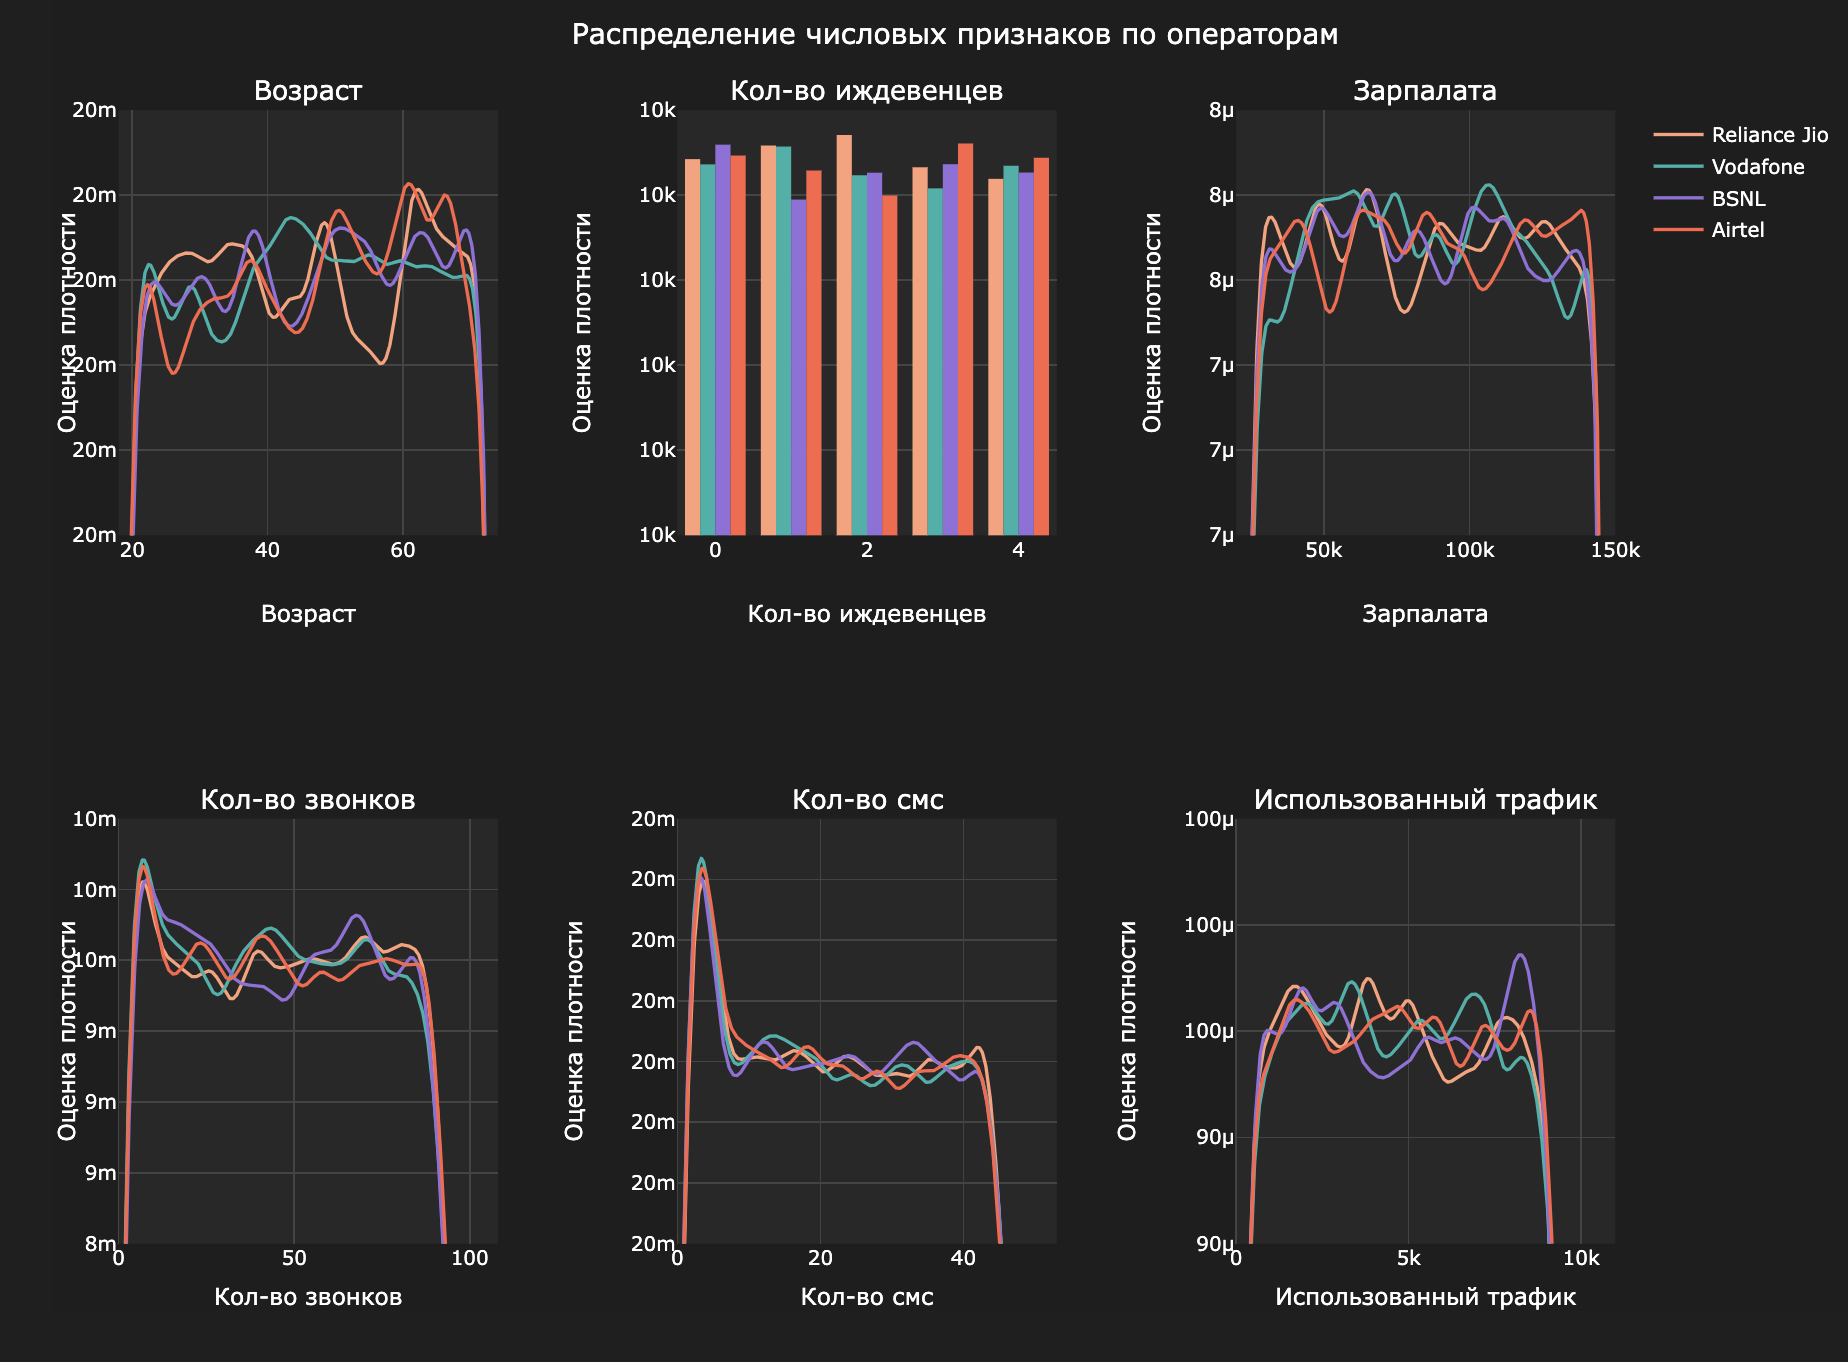

Reliance Jio в основном используется молодыми пользователями, но также имеет значительную долю представителей взрослого и пожилого поколения. На графике распределения звонков видно, что оно наиболее сглаженное среди всех операторов, что означает наличие разнообразного количества звонков — как с небольшим числом (например, 7 звонков), так и с большим (до 100 звонков).

Для повышения кол-ва звонков у оператора Vodafone можно:

* предложить акционные предложения пользователям с мнимальным кол - вом звонков
* привлечь молодое поколение в юзеры путем рекламной компании

# Построение точечной и интервальной оценки (сделаю через бутстрап)

In [57]:
# Функция для бутстрэпа
def bootstrap_ci(data1, data2, n_iterations=1000, ci=95):
    """
    data1, data2: два массива данных для сравнения
    n_iterations: количество итераций для бутстрэпа
    ci: доверительный интервал (например, 95%)
    """
    # для хранения разниц
    diff_means = []

    # Бутстрэп-выборки
    for _ in range(n_iterations):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diff_means.append(np.mean(sample1) - np.mean(sample2))
    
    # доверительный интервал
    lower = np.percentile(diff_means, (100 - ci) / 2)
    upper = np.percentile(diff_means, 100 - (100 - ci) / 2)
    
    return np.mean(diff_means), lower, upper

def compare_groups_with_ci(df, group1, group2, column, category):
    """
    Функция для вычисления точечной оценки и доверительного интервала для разницы между двумя группами.
    
    df: исходный DataFrame
    group1, group2: названия двух групп для сравнения
    column: столбец, по которому будет сравнение
    category: категория для группировки (например, "telecom_partner" или "state")
    """
    
    data1 = df[df[category] == group1][column]
    data2 = df[df[category] == group2][column]

    # Точечная оценка (разница средних значений)
    point_estimate = np.mean(data1) - np.mean(data2)

    # Интервальная оценка через бутстрэп
    mean_diff, lower_ci, upper_ci = bootstrap_ci(data1, data2, n_iterations=1000)

    print(f"\nТочечная оценка разницы для {group1} и {group2}: {point_estimate:.4f}")
    print(f"Доверительный интервал для разницы: ({lower_ci:.4f}, {upper_ci:.4f})")
    print(f"Среднее через бутстрэп: {mean_diff:.4f}")

In [58]:
# Сравниваем по операторам звонки
compare_groups_with_ci(df_v1, "Reliance Jio", "Vodafone", "calls_made", "telecom_partner")
compare_groups_with_ci(df_v1, "Reliance Jio", "BSNL", "calls_made", "telecom_partner")
compare_groups_with_ci(df_v1, "Reliance Jio", "Airtel", "calls_made", "telecom_partner")
compare_groups_with_ci(df_v1, "Vodafone", "BSNL", "calls_made", "telecom_partner")
compare_groups_with_ci(df_v1, "Vodafone", "Airtel", "calls_made", "telecom_partner")
compare_groups_with_ci(df_v1, "BSNL", "Airtel", "calls_made", "telecom_partner")



Точечная оценка разницы для Reliance Jio и Vodafone: 0.4183
Доверительный интервал для разницы: (0.0747, 0.7236)
Среднее через бутстрэп: 0.4125

Точечная оценка разницы для Reliance Jio и BSNL: 0.1600
Доверительный интервал для разницы: (-0.1578, 0.5173)
Среднее через бутстрэп: 0.1669

Точечная оценка разницы для Reliance Jio и Airtel: 0.1739
Доверительный интервал для разницы: (-0.1714, 0.5003)
Среднее через бутстрэп: 0.1677

Точечная оценка разницы для Vodafone и BSNL: -0.2583
Доверительный интервал для разницы: (-0.5793, 0.0463)
Среднее через бутстрэп: -0.2609

Точечная оценка разницы для Vodafone и Airtel: -0.2444
Доверительный интервал для разницы: (-0.5664, 0.0896)
Среднее через бутстрэп: -0.2418

Точечная оценка разницы для BSNL и Airtel: 0.0139
Доверительный интервал для разницы: (-0.3325, 0.3373)
Среднее через бутстрэп: 0.0142


В целом, среднее значение через бутсрэп и через точечуню оценку дают очень близкие результаты.

Как и показал тест Манна - Уитни: есть статзначимое различие между операторами Reliance Jio и Vodafone (доверительный интервал не захватывает 0). А положительное значение среднего показывает, что у оператора Reliance Jio совершают больше звонков, чем у оператора Vodafone

## №2

- Reliance Jio и Vodafone
- Reliance Jio и BSNL
- Reliance Jio и Airtel
- Vodafone и BSNL
- Vodafone и Airtel
- BSNL и Airtel

Аналогично сделаю для дата трафика:

И проверим: есть ли разница между средним растраченным трафиком у каждого оператора. Для этого сначала пробегусь ANOVA:

$H_0$: Средние значения всех групп одинаковы (нет статистически значимых различий).
$H_1$: Хотя бы одна группа имеет среднее значение, отличное от других.

А затем попарно сравню через Манна-Уитни:

$H_0$: Распределения для двух групп одинаковы

$H_1$: Распределения для двух групп различаются (распределения одинаковые, но одно распределение смещено относительно другого)


In [50]:
data_column = "data_used"

# ANOVA
def anova_test(df, operators, column):
    # данные по каждому оператору
    groups = [df[df["telecom_partner"] == operator][column] for operator in operators]
    
    f_stat, p_val = f_oneway(*groups)
    
    print("Результаты ANOVA:")
    print(f"F-статистика: {f_stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print("Есть статистически значимые различия между группами.")
    else:
        print("Нет статистически значимых различий между группами.")
    
# Манна-Уитни
def mann_whitney_test(df, operator1, operator2, column):
    data1 = df[df["telecom_partner"] == operator1][column]
    data2 = df[df["telecom_partner"] == operator2][column]
    
    stat, p_val = mannwhitneyu(data1, data2)
    
    print(f"\nРезультаты Манна-Уитни для {operator1} и {operator2}:")
    print(f"Статистика: {stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"Есть статистически значимые различия между {operator1} и {operator2}.")
    else:
        print(f"Нет статистически значимых различий между {operator1} и {operator2}.")

# Выполнение функций
anova_test(df_v1, operators, data_column)

pairs = [
    ("Reliance Jio", "Vodafone"),
    ("Reliance Jio", "BSNL"),
    ("Reliance Jio", "Airtel"),
    ("Vodafone", "BSNL"),
    ("Vodafone", "Airtel"),
    ("BSNL", "Airtel")
]

for operator1, operator2 in pairs:
    mann_whitney_test(df_v1, operator1, operator2, data_column)

Результаты ANOVA:
F-статистика: 1.2114, p-значение: 0.3038
Нет статистически значимых различий между группами.

Результаты Манна-Уитни для Reliance Jio и Vodafone:
Статистика: 1851706136.5000, p-значение: 0.2906
Нет статистически значимых различий между Reliance Jio и Vodafone.

Результаты Манна-Уитни для Reliance Jio и BSNL:
Статистика: 1845416778.0000, p-значение: 0.0912
Нет статистически значимых различий между Reliance Jio и BSNL.

Результаты Манна-Уитни для Reliance Jio и Airtel:
Статистика: 1852226901.0000, p-значение: 0.1382
Нет статистически значимых различий между Reliance Jio и Airtel.

Результаты Манна-Уитни для Vodafone и BSNL:
Статистика: 1842166193.0000, p-значение: 0.5264
Нет статистически значимых различий между Vodafone и BSNL.

Результаты Манна-Уитни для Vodafone и Airtel:
Статистика: 1848980415.0000, p-значение: 0.6723
Нет статистически значимых различий между Vodafone и Airtel.

Результаты Манна-Уитни для BSNL и Airtel:
Статистика: 1850467536.5000, p-значение: 0.831

# Вывод

А вот по дата трафику статзначимых различий между операторами не было выявлено

Подтвердим это через точечную и интервальную оценки: если интервал захватывает 0, значит статзначимых различий не наблюдается (нельзя отвергнуть нулевую гипотезу ($H_0$).)

In [59]:
# Сравниваем по операторам трафику
compare_groups_with_ci(df_v1, "Reliance Jio", "Vodafone", "data_used", "telecom_partner")
compare_groups_with_ci(df_v1, "Reliance Jio", "BSNL", "data_used", "telecom_partner")
compare_groups_with_ci(df_v1, "Reliance Jio", "Airtel", "data_used", "telecom_partner")
compare_groups_with_ci(df_v1, "Vodafone", "BSNL", "data_used", "telecom_partner")
compare_groups_with_ci(df_v1, "Vodafone", "Airtel", "data_used", "telecom_partner")
compare_groups_with_ci(df_v1, "BSNL", "Airtel", "data_used", "telecom_partner")


Точечная оценка разницы для Reliance Jio и Vodafone: -18.9910
Доверительный интервал для разницы: (-52.7981, 14.5995)
Среднее через бутстрэп: -18.9470

Точечная оценка разницы для Reliance Jio и BSNL: -29.7508
Доверительный интервал для разницы: (-63.0295, 4.4259)
Среднее через бутстрэп: -29.8164

Точечная оценка разницы для Reliance Jio и Airtel: -25.3232
Доверительный интервал для разницы: (-57.9347, 6.7510)
Среднее через бутстрэп: -25.6128

Точечная оценка разницы для Vodafone и BSNL: -10.7598
Доверительный интервал для разницы: (-45.7807, 24.7071)
Среднее через бутстрэп: -10.4733

Точечная оценка разницы для Vodafone и Airtel: -6.3323
Доверительный интервал для разницы: (-39.5635, 25.2634)
Среднее через бутстрэп: -6.4461

Точечная оценка разницы для BSNL и Airtel: 4.4275
Доверительный интервал для разницы: (-28.2452, 38.0464)
Среднее через бутстрэп: 4.5788


## №3

- Bihar и Goa
- Bihar и Maharashtra
- Bihar и Karnataka
- Goa и Maharashtra
- Goa и Karnataka
- Maharashtra и Karnataka

Также через ANOVA и тест Манна-Уитни посмотрю различается ли зарплата в разных штатах.

In [51]:
state_4 = ["Bihar", "Goa", "Maharashtra", "Karnataka"]
salary_column = "estimated_salary"

# ANOVA
def anova_test(df, states, column):
    # данные по каждому штату
    groups = [df[df["state"] == state][column] for state in states]
    
    f_stat, p_val = f_oneway(*groups)
    
    print("Результаты ANOVA:")
    print(f"F-статистика: {f_stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print("Есть статистически значимые различия между штатами.")
    else:
        print("Нет статистически значимых различий между штатами.")
    
# Манна-Уитни
def mann_whitney_test(df, state1, state2, column):
    data1 = df[df["state"] == state1][column]
    data2 = df[df["state"] == state2][column]
    
    stat, p_val = mannwhitneyu(data1, data2)
    
    print(f"\nРезультаты Манна-Уитни для {state1} и {state2}:")
    print(f"Статистика: {stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"Есть статистически значимые различия между {state1} и {state2}.")
    else:
        print(f"Нет статистически значимых различий между {state1} и {state2}.")

# Выполнение функции ANOVA для всех штатов
anova_test(df_v1, state_4, salary_column)

# Попарное сравнение через тест Манна-Уитни
pairs = [
    ("Bihar", "Goa"),
    ("Bihar", "Maharashtra"),
    ("Bihar", "Karnataka"),
    ("Goa", "Maharashtra"),
    ("Goa", "Karnataka"),
    ("Maharashtra", "Karnataka")
]

for state1, state2 in pairs:
    mann_whitney_test(df_v1, state1, state2, salary_column)

Результаты ANOVA:
F-статистика: 1.1428, p-значение: 0.3302
Нет статистически значимых различий между штатами.

Результаты Манна-Уитни для Bihar и Goa:
Статистика: 37209691.5000, p-значение: 0.3341
Нет статистически значимых различий между Bihar и Goa.

Результаты Манна-Уитни для Bihar и Maharashtra:
Статистика: 37783923.5000, p-значение: 0.3875
Нет статистически значимых различий между Bihar и Maharashtra.

Результаты Манна-Уитни для Bihar и Karnataka:
Статистика: 38383969.5000, p-значение: 0.5397
Нет статистически значимых различий между Bihar и Karnataka.

Результаты Манна-Уитни для Goa и Maharashtra:
Статистика: 38379790.0000, p-значение: 0.9066
Нет статистически значимых различий между Goa и Maharashtra.

Результаты Манна-Уитни для Goa и Karnataka:
Статистика: 38984019.5000, p-значение: 0.1107
Нет статистически значимых различий между Goa и Karnataka.

Результаты Манна-Уитни для Maharashtra и Karnataka:
Статистика: 39511267.5000, p-значение: 0.1363
Нет статистически значимых различ

# Вывод

По зарплате статзначимых различий между штатами не было выявлено. Я думаю это связано с тем, что пики на распределении зп не такие большие, чтобы их можно было статзначимо задетектить, и что все же зп распределена более менее равномерно:

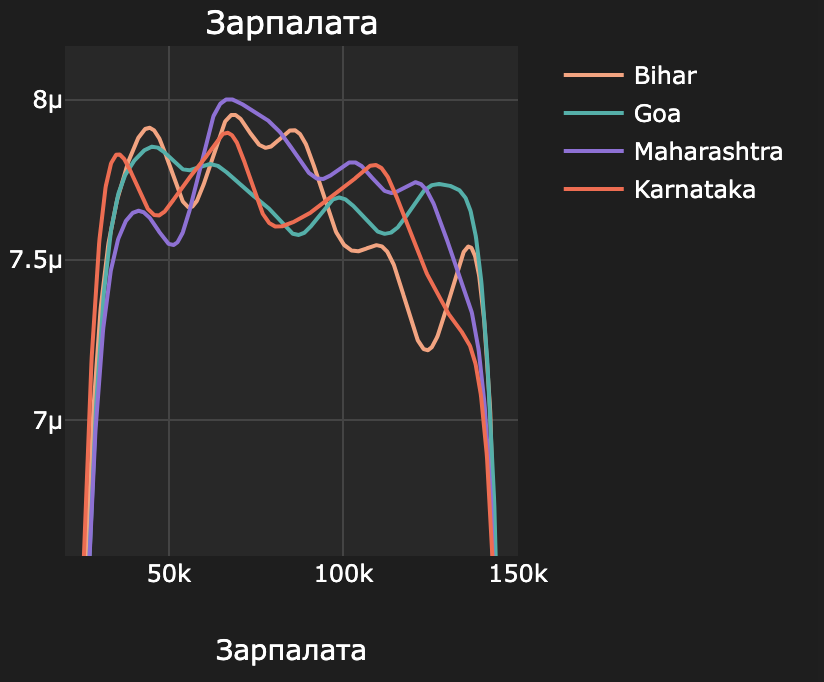

In [60]:
# Сравниваем по штатам зарплату
compare_groups_with_ci(df_v1, "Bihar", "Goa", "estimated_salary", "state")
compare_groups_with_ci(df_v1, "Bihar", "Maharashtra", "estimated_salary", "state")
compare_groups_with_ci(df_v1, "Bihar", "Karnataka", "estimated_salary", "state")
compare_groups_with_ci(df_v1, "Goa", "Maharashtra", "estimated_salary", "state")
compare_groups_with_ci(df_v1, "Goa", "Karnataka", "estimated_salary", "state")
compare_groups_with_ci(df_v1, "Maharashtra", "Karnataka", "estimated_salary", "state")


Точечная оценка разницы для Bihar и Goa: -554.2178
Доверительный интервал для разницы: (-1596.3891, 578.8553)
Среднее через бутстрэп: -559.2500

Точечная оценка разницы для Bihar и Maharashtra: -486.6483
Доверительный интервал для разницы: (-1600.5456, 549.5744)
Среднее через бутстрэп: -520.0901

Точечная оценка разницы для Bihar и Karnataka: 349.6241
Доверительный интервал для разницы: (-811.8205, 1392.7132)
Среднее через бутстрэп: 311.2454

Точечная оценка разницы для Goa и Maharashtra: 67.5695
Доверительный интервал для разницы: (-1044.0515, 1203.5297)
Среднее через бутстрэп: 51.2273

Точечная оценка разницы для Goa и Karnataka: 903.8420
Доверительный интервал для разницы: (-177.5448, 2077.3698)
Среднее через бутстрэп: 914.8241

Точечная оценка разницы для Maharashtra и Karnataka: 836.2725
Доверительный интервал для разницы: (-217.6778, 1951.6723)
Среднее через бутстрэп: 829.9280



## №4

- Delhi и Mumbai
- Delhi и Bangalore
- Mumbai и Bangalore

Также через ANOVA и тест Манна-Уитни посмотрю различается ли кол-во отправленых смс в разных городах.

In [ ]:
city_3 = ["Delhi", "Mumbai", "Bangalore"]
sms_column = "sms_sent"

# ANOVA
def anova_test(df, cities, column):
    # данные по каждому городу
    groups = [df[df["city"] == city][column] for city in cities]
    
    f_stat, p_val = f_oneway(*groups)
    
    print("Результаты ANOVA:")
    print(f"F-статистика: {f_stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print("Есть статистически значимые различия между городами.")
    else:
        print("Нет статистически значимых различий между городами.")
    
# Манна-Уитни
def mann_whitney_test(df, city1, city2, column):
    data1 = df[df["city"] == city1][column]
    data2 = df[df["city"] == city2][column]
    
    stat, p_val = mannwhitneyu(data1, data2)
    
    print(f"\nРезультаты Манна-Уитни для {city1} и {city2}:")
    print(f"Статистика: {stat:.4f}, p-значение: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"Есть статистически значимые различия между {city1} и {city2}.")
    else:
        print(f"Нет статистически значимых различий между {city1} и {city2}.")

# Выполнение функции ANOVA для всех городов
anova_test(df_v1, city_3, sms_column)

# Попарное сравнение через тест Манна-Уитни
pairs = [
    ("Delhi", "Mumbai"),
    ("Delhi", "Bangalore"),
    ("Mumbai", "Bangalore")
]

for city1, city2 in pairs:
    mann_whitney_test(df_v1, city1, city2, sms_column)

Результаты ANOVA:
F-статистика: 0.9517, p-значение: 0.3861
Нет статистически значимых различий между городами.

Результаты Манна-Уитни для Delhi и Mumbai:
Статистика: 812252645.0000, p-значение: 0.1587
Нет статистически значимых различий между Delhi и Mumbai.

Результаты Манна-Уитни для Delhi и Bangalore:
Статистика: 819576910.5000, p-значение: 0.6012
Нет статистически значимых различий между Delhi и Bangalore.

Результаты Манна-Уитни для Mumbai и Bangalore:
Статистика: 822835278.5000, p-значение: 0.3769
Нет статистически значимых различий между Mumbai и Bangalore.


# Вывод

По смс статзначимых различий между гордами не было выявлено

In [61]:
# Сравниваем по городам смс
compare_groups_with_ci(df_v1, "Delhi", "Mumbai", "sms_sent", "city")
compare_groups_with_ci(df_v1, "Delhi", "Bangalore", "sms_sent", "city")
compare_groups_with_ci(df_v1, "Mumbai", "Bangalore", "sms_sent", "city")


Точечная оценка разницы для Delhi и Mumbai: -0.1413
Доверительный интервал для разницы: (-0.3497, 0.0631)
Среднее через бутстрэп: -0.1407

Точечная оценка разницы для Delhi и Bangalore: -0.0520
Доверительный интервал для разницы: (-0.2451, 0.1681)
Среднее через бутстрэп: -0.0511

Точечная оценка разницы для Mumbai и Bangalore: 0.0893
Доверительный интервал для разницы: (-0.1124, 0.2840)
Среднее через бутстрэп: 0.0906


# Регрессионный анализ

1) Оценить модель линейной регрессии методом МНК, подготовить репорт модели и проинтерпретировать оценки коэффициентов.

2) Провести тесты на гетероскедастичность, мультиколлинеарность (как визуальные, так и численные), дать комментарии по произведенным тестам. В случае нарушения предпосылок Гаусса-Маркова – принять соответствующие корректирующие модель действия, после чего повторить пункт 1.

3) В ходе анализа протестируйте как минимум 2 спецификации моделей. Финальная спецификация модели может включать не все факторы и не все наблюдения из исходной выборки. Продемонстрируйте на примере финальной и одной из промежуточных моделей, по каким критериям и метрикам был произведен выбор в пользу финальной спецификации. Дайте трактовку значениям этих критериев и метрик.